In [1]:
from config.batched_separate_dropout2.separate_3_1 import config
config

{'threshold': 1.5,
 'datapath': '../../../climate/sim-data/preproc/',
 'filenames_sims': ['tas_anual_preproc_ssp126_MIROC6.nc'],
 'context': 'ssp&model',
 'context_aware': False,
 'prior_range_override': [-40, 41],
 'year_bounds': [1970, 2100],
 'checkpoint_path': 'checkpoints/batched_separate_dropout2/separate_3_1',
 'presimulate_path': 'checkpoints/presims-3/',
 'n': 1,
 'summary_net': {'type': 'dense',
  'kwargs': {'hidden_units': [25, 25],
   'output_dim': 4,
   'zeroth_layer': {'dropout': 0.4}}},
 'inference_net': {'type': 'bf-invertible',
  'kwargs': {'num_params': 2, 'num_coupling_layers': 1}},
 'member_split': {'train': [0, 1, 2, 3, 4, 5, 6], 'val': [7, 8], 'test': [9]},
 'epochs': 15,
 'iterations_per_epoch': 60,
 'batch_size': 32,
 'rng_seed': 2023}

In [2]:
import numpy as np
import pandas as pd
import os
import sys

sys.path.append(os.path.abspath(os.path.join('../../../BayesFlow/')))
sys.path.append(os.path.abspath(os.path.join('../..')))  # access sibling directories
from src.python.helpers import _configure_input, format_names, estimate_data_means_and_stds
from src.python.visualization import build_climate_model_color_dict

from setup import *

2024-02-07 00:40:33.657279: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/ho/code/BayesFlow/bayesflow/trainers.py:27: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
RNG = np.random.default_rng(config['rng_seed'])

In [4]:
DATAPATH = config['datapath']
datasets = load_datasets(config, data_path=DATAPATH)
model_names = list(datasets.keys())

model = build_generative_model(config, datasets, RNG)

train_data_dict = OrderedDict((key, datasets[key].TAS.isel(member=config['member_split']['train']) - datasets[key].TAS_baseline) for key in datasets.keys())
data_means, data_stds = estimate_data_means_and_stds(train_data_dict)
prior_means, prior_stds = model.prior.estimate_means_and_stds()

context_aware = config['context_aware'] if 'context_aware' in config else True
configure_input = partial(_configure_input, prior_means=prior_means, prior_stds=prior_stds, data_means=data_means, data_stds=data_stds, context=config['context'], context_aware=context_aware)

amortizer = build_amortizer(config)

trainer = Trainer(
    amortizer=amortizer, configurator=configure_input, checkpoint_path=config['checkpoint_path'],
    generative_model=model, memory=True, reuse_optimizer=True,
)

INFO:root:Using uniform prior on time-to-threshold between -40 and 41.
INFO:root:Using the following climate models: ['ssp126_MIROC6']


INFO:root:Performing 2 pilot runs with the anonymous model...
INFO:root:Shape of parameter batch after 2 pilot simulations: (batch_size = 2, 2)
INFO:root:Shape of simulation batch after 2 pilot simulations: (batch_size = 2, 72, 144)
INFO:root:No optional prior non-batchable context provided.
INFO:root:No optional prior batchable context provided.
INFO:root:No optional simulation non-batchable context provided.
INFO:root:Could not determine shape of simulation batchable context. Type appears to be non-array: <class 'list'>,                                    so make sure your input configurator takes cares of that!
INFO:root:Built generative model for temperature maps parametrized by the years before the warming threshold 1.5°C is reached.
2024-02-07 00:40:36.234870: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.
INFO:root:Loaded loss history from checkpoints/b

In [5]:
history = trainer.loss_history.get_plottable()

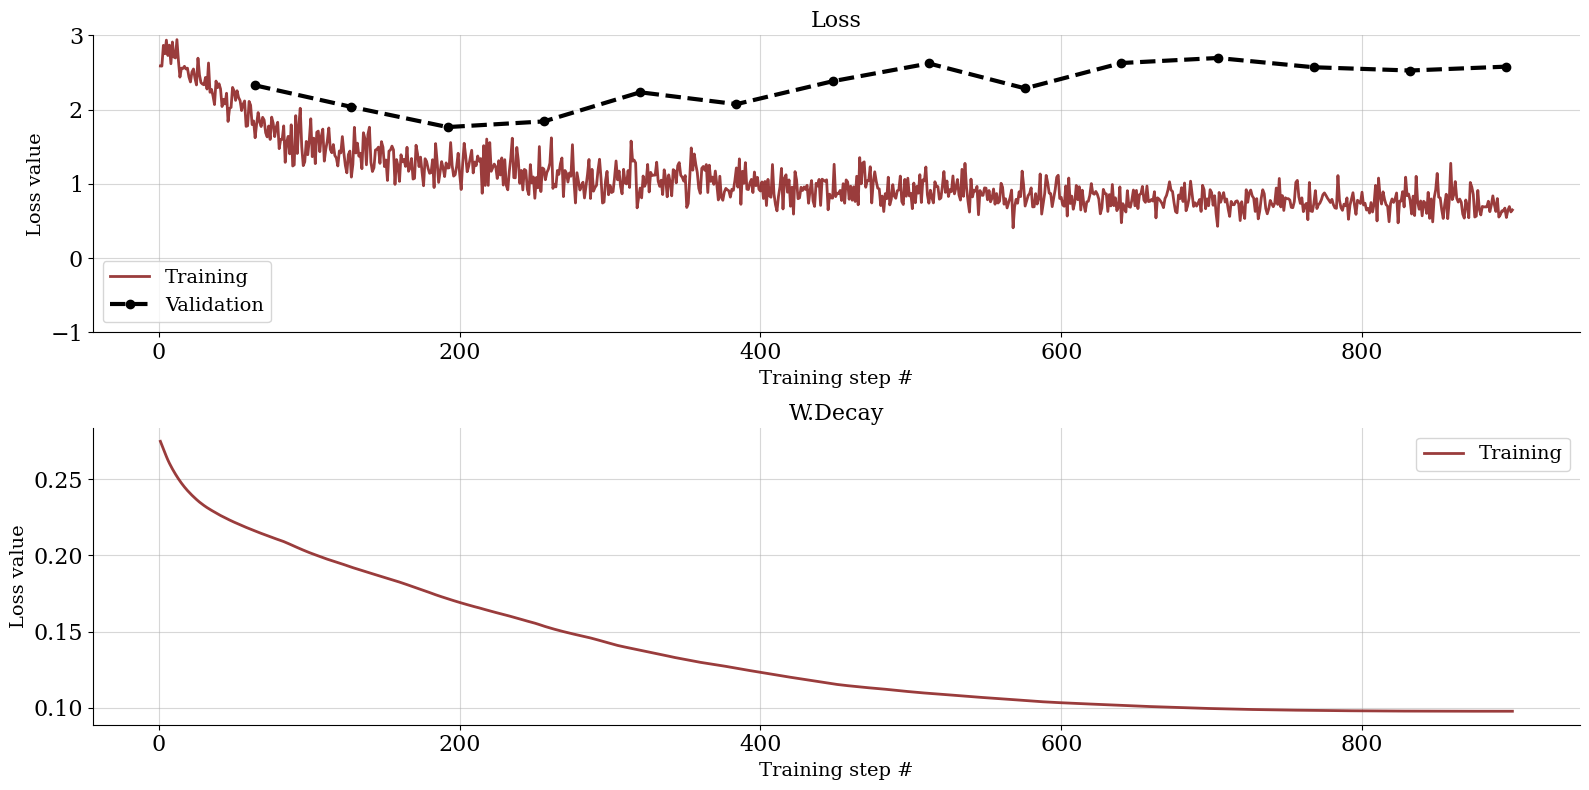

In [6]:
f = diag.plot_losses(history["train_losses"], history["val_losses"])
f.axes[0].set_ylim(-1, 3)
f.savefig(os.path.join(config['checkpoint_path'], 'climate_losses.pdf'), bbox_inches='tight')

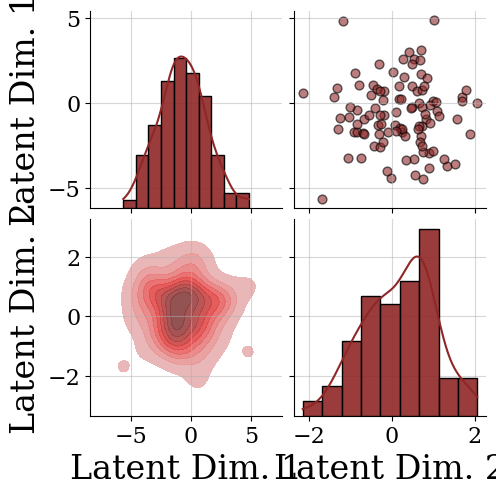

In [7]:
val_sims = model(100, sim_args= {'state':'val'})
f = trainer.diagnose_latent2d(val_sims)

## Mean Absolute Error

To validate the accuracy of the models, we compute the mean absolute error. 

To compare with Diffenbaugh and Barnes method that works on the marginal distribution, we can marginalize predictions over different climate model contexts.

First, with the help of the generative model as an interface to the simulated datasets:

In [8]:
metrics = {}    # keep track of metrics for this run

# To speed up the validation process, we can use pre-simulated train and validation data. If the path to the pre-simulated data is
# not provided in the config, we will simulate the data here. If the path is provided, we will load the data and compute
# the loss.

try:
    if not 'presimulate_path' in config.keys():
        raise KeyError("No presimulate_path in config")

    for state in ['train', 'val']:
        sims_path = os.path.join(config['presimulate_path'], f'presim_{state}.pkl')
        if not os.path.exists(sims_path):
            raise FileNotFoundError(f"Could not find pre-simulated data at {sims_path}")

        sims = np.load(sims_path, allow_pickle=True)
        data = trainer.configurator(sims)
        loss = amortizer.compute_loss(data).numpy()

        metrics[f'{state}_loss'] = {'mean':loss, 'std':None}
        print(f"{state.capitalize()} loss: {loss:.3f}")

        # name in same format as freshly simulated data
        if state == 'train':
            train_data = data
        elif state == 'val':
            val_data = data
        else:
            raise ValueError(f"Unknown state: {state}")

# if no pre-simulated data is available, simulate it here
except (KeyError, FileNotFoundError) as e:
    # Generate and compute loss for train data
    train_loss_batches = []
    train_data_list = []
    for _ in range(10):
        sims_train = trainer.generative_model(batch_size=100, sim_args={'state': 'train'})
        batch_train_data = trainer.configurator(sims_train)
        train_loss_batches.append(amortizer.compute_loss(batch_train_data).numpy())
        train_data_list.append(batch_train_data)

    train_data = {}
    for key in train_data_list[0].keys(): # concatenate the data from the different batches
        train_data[key] = np.concatenate([train_data_list[i][key] for i in range(len(train_data_list))], axis=0)

    metrics['train_loss'] = {'mean': np.mean(train_loss_batches), 'std': np.std(train_loss_batches)}
    print(f"Train loss: {metrics['train_loss']['mean']:.3f} ± {metrics['train_loss']['std']:.3f}")
    del sims_train, batch_train_data    # free up memory


    # Generate and compute loss for validation data
    val_loss_batches = []
    val_data_list = []
    for _ in range(10):
        sims_val = trainer.generative_model(batch_size=500, sim_args={'state': 'val'})
        batch_val_data = trainer.configurator(sims_val)
        val_loss_batches.append(amortizer.compute_loss(batch_val_data).numpy())
        val_data_list.append(batch_val_data)

    val_data = {}
    for key in val_data_list[0].keys(): # concatenate the data from the different batches
        val_data[key] = np.concatenate([val_data_list[i][key] for i in range(len(val_data_list))], axis=0)

    metrics['val_loss'] = {'mean': np.mean(val_loss_batches), 'std': np.std(val_loss_batches)}
    print(f"Val loss:   {metrics['val_loss']['mean']:.3f} ± {metrics['val_loss']['std']:.3f}")
    del sims_val, batch_val_data    # free up memory

Train loss: 0.563
Val loss: 2.612


# Calibration + ABI Recovery

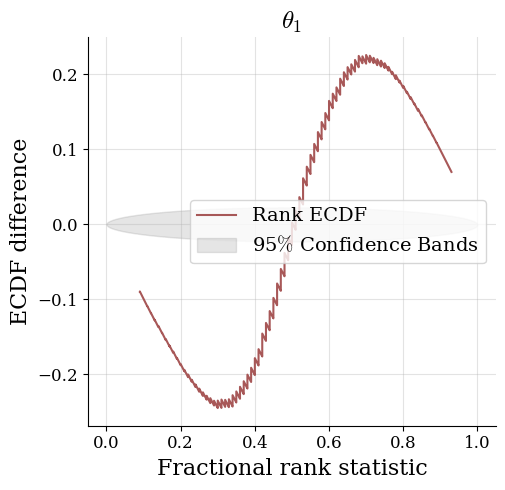

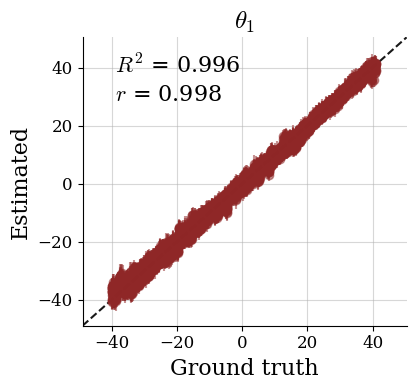

In [9]:
# Sample for each prior context
samples_train_data = amortizer.sample(
    train_data,
    n_samples=100,
    to_numpy=True,
)

f = diag.plot_sbc_ecdf(samples_train_data *prior_stds + prior_means,
                       train_data['parameters'] *prior_stds + prior_means, difference=True)
f.delaxes(f.axes[1])

f = diag.plot_recovery(samples_train_data *prior_stds + prior_means,
                       train_data['parameters'] *prior_stds + prior_means)
f.delaxes(f.axes[1])

In [10]:
# Sample for each prior context
samples = amortizer.sample(
    val_data,
    n_samples=100,
    to_numpy=True,
)

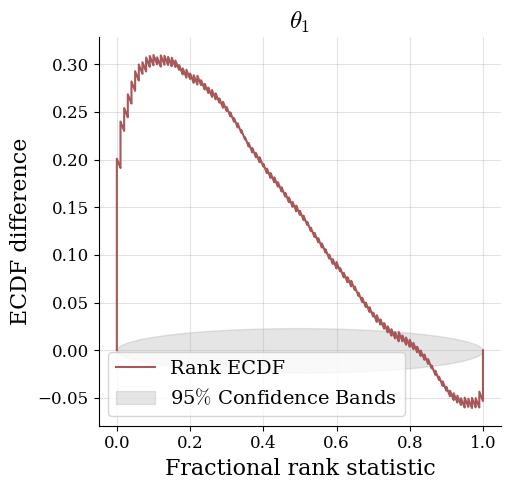

In [11]:
f = diag.plot_sbc_ecdf(samples*prior_stds+prior_means,
                       val_data['parameters']*prior_stds+prior_means, difference=True)
f.delaxes(f.axes[1])

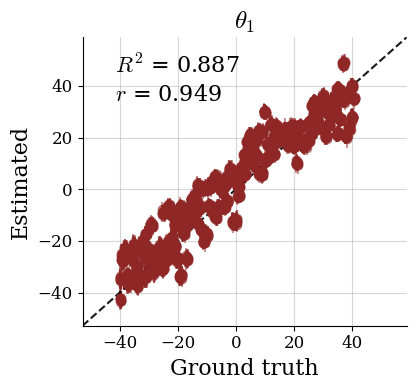

In [12]:
f = diag.plot_recovery(samples*prior_stds+prior_means,
                       val_data['parameters']*prior_stds+prior_means)
f.delaxes(f.axes[1])

In [13]:
import pickle

# Export metrics
with open(os.path.join(config['checkpoint_path'], 'metrics.pkl'), 'wb') as f:
    pickle.dump(metrics, f)
